In [7]:
from encodingUtils import encode, PlaceCellEncoder2D
theta0=90

sigma_res_noise = 0.005
sigma_S = 0.002

spatial_res = 5

gamma_pg=0.5

gradient_spectral_rad = .5

description='rho=' + str(gradient_spectral_rad) + '_5'

grid_size = spatial_res  
sigma = 0.2 

encoder = PlaceCellEncoder2D(grid_size, sigma)

In [8]:
from envAgent import Environment, LinearAgent
import numpy as np

# BUG: Agent in the environment was not designed to be called
# as any other variable BUT agent, this caused problems (maybe) with agent_res
env = Environment()
agent = LinearAgent()

agent.weights_0 = np.copy(agent.weights)

In [9]:
from goal_onr import RESERVOIRE_SIMPLE_NL_MULT

# Changed time from 600 to 1200
N, I, O, TIME = 2000, 15, 7, 30
shape = (N, I, O, TIME)

dt = 1.0/ TIME 
tau_m_f = 20. * dt
tau_m_s = 20. * dt
tau_s = 2. * dt
tau_ro = .001 * dt
beta_s  = np.exp (-dt / tau_s)
beta_ro = np.exp (-dt / tau_ro)
sigma_teach = 0.
sigma_input = .06
sigma_rec = 0.5/np.sqrt(N)
offT = 1
dv = 5.
alpha_rout = .0005 
alpha_pg = 0.0005
alpha = 0.
Vo = 0
h = 0
s_inh = 0
sigma_output = .1

n_electrodes = 85
n_pca = n_electrodes

par = {'tau_m_f' : tau_m_f,'tau_m_s' : tau_m_s, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'beta_ro' : beta_ro,
    'dv' : dv, 'alpha' : alpha, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
    'N' : N, 'T' : TIME, 'dt' : dt, 'offT' : offT, 'alpha_rout' : alpha_rout,
    'sigma_input' : sigma_input, 'sigma_teach' : sigma_teach,'sigma_rec' : sigma_rec, 'shape' : shape,'sigma_output':sigma_output}

N = 500
# Change to 1 if you want to use the 1 - strategy
gamma_grad = 1.5
input_dim = spatial_res**2 + 4 + 10
shape = ( N , input_dim , 4*spatial_res**2 , TIME )
par['shape']=shape
par['sigma_input'] = sigma_input
par['sigma_rec'] = gradient_spectral_rad/np.sqrt(N)
par['tau_m_s'] = .00*dt
par['tau_m_f'] = .00*dt
network_reservoire_gradient = RESERVOIRE_SIMPLE_NL_MULT (par)
network_reservoire_gradient.Jin_mult = np.random.normal(0,0.1,size=(N,))

In [10]:
ERRORS = []

alpha_w = 0.05

r_traj = []
e_traj = []
dw_traj = []
r_targ = []
y_data = []
S = []

x_net_coll = []
y_coll = []

x_grad_net_coll = []
y_grad_coll = []

x_w_coll = []
y_w_coll = []

In [54]:
from tqdm import tqdm

change_every = 600
n_resets = 16

eta = 0.008 * 0.125

dw_filt = 0
n_angle = 0

total_rewards = []
total_reservoire_rates = []
total_gradients = []

for n in tqdm(range(n_resets), desc='Resets', total=n_resets):
    theta0 = 45 * n_angle
    n_angle += 1 

    env.reset(.5,.5, theta0=theta0)
    agent.weights = np.copy(agent.weights_0 * 0)

    rewards = []
    reservoire_rates = []
    gradients = []

    for episode in range(change_every):
        done = False 
        time = 0

        env.reset_inner()
        network_reservoire_gradient.reset()
        agent.update_filt = np.copy(agent.weights_0 * 0)

        reservoire_rate = []
        gradient = []
        
        while not done:
            time += 1
            if time >= TIME:
                break
            
            state = np.copy(env.agent_position)
            state_enc = encoder.encode_position(state)
            logits = agent.weights @ state_enc
            action_probs = np.exp(logits) / np.sum(np.exp(logits))
            action = np.random.choice(len(action_probs), p=action_probs)

            reward, done = env.step(action)
            weights_old = np.copy(agent.weights)
            probs = np.copy(action_probs)
            probs[action] -= 1
            agent.update_filt = agent.update_filt*gamma_pg + (1.-gamma_pg)* np.outer(probs,state_enc)
            dw_out = np.copy(-reward * agent.learning_rate * agent.update_filt) * eta
            agent.weights += dw_out

            r_encoded = encode(reward)

            input_modulation = .1 + gamma_grad * network_reservoire_gradient.Jin_mult * reward
            input_modulation = input_modulation.flatten()

            reservoire_input = np.concatenate((state_enc, probs, r_encoded.flatten()))
            network_reservoire_gradient.step_rate(reservoire_input, input_modulation, 0)

            reservoire_rate.append(network_reservoire_gradient.S)
            gradient.append(dw_out.flatten())

        flat_shape = dw_out.flatten().shape
        # When the episode ends prematurely, pad the reservoire_rate and gradient lists
        if len(gradient) < TIME:
            pad_vec = np.zeros(flat_shape)
            gradient += [pad_vec] * (TIME - len(gradient))
            reservoire_rate += [np.zeros(N)] * (TIME - len(reservoire_rate))

        reservoire_rates.append(reservoire_rate)
        gradients.append(gradient)
        rewards.append(reward)  

    total_reservoire_rates.append(reservoire_rates)
    total_gradients.append(gradients)
    total_rewards.append(rewards)      
        
total_rewards = np.array(total_rewards)
total_reservoire_rates = np.array(total_reservoire_rates)
total_gradients = np.array(total_gradients)

print(total_rewards.shape)
print(total_reservoire_rates.shape)
print(total_gradients.shape)

Resets:   0%|          | 0/16 [00:00<?, ?it/s]c:\Users\marcu\Desktop\github repos\AML2025\FinalProject\Testing\goal_onr.py:131: RuntimeWarning: divide by zero encountered in divide
  self.H   = self.H   * np.exp(-self.dt/self.tau_m) + (1-np.exp(-self.dt/self.tau_m) ) * np.tanh( ( self.J @ self.S_hat   + self.Jin @ inp )* (inp_modulation) )
Resets: 100%|██████████| 16/16 [01:24<00:00,  5.26s/it]


(16, 600)
(16, 600, 30, 500)
(16, 600, 30, 100)



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


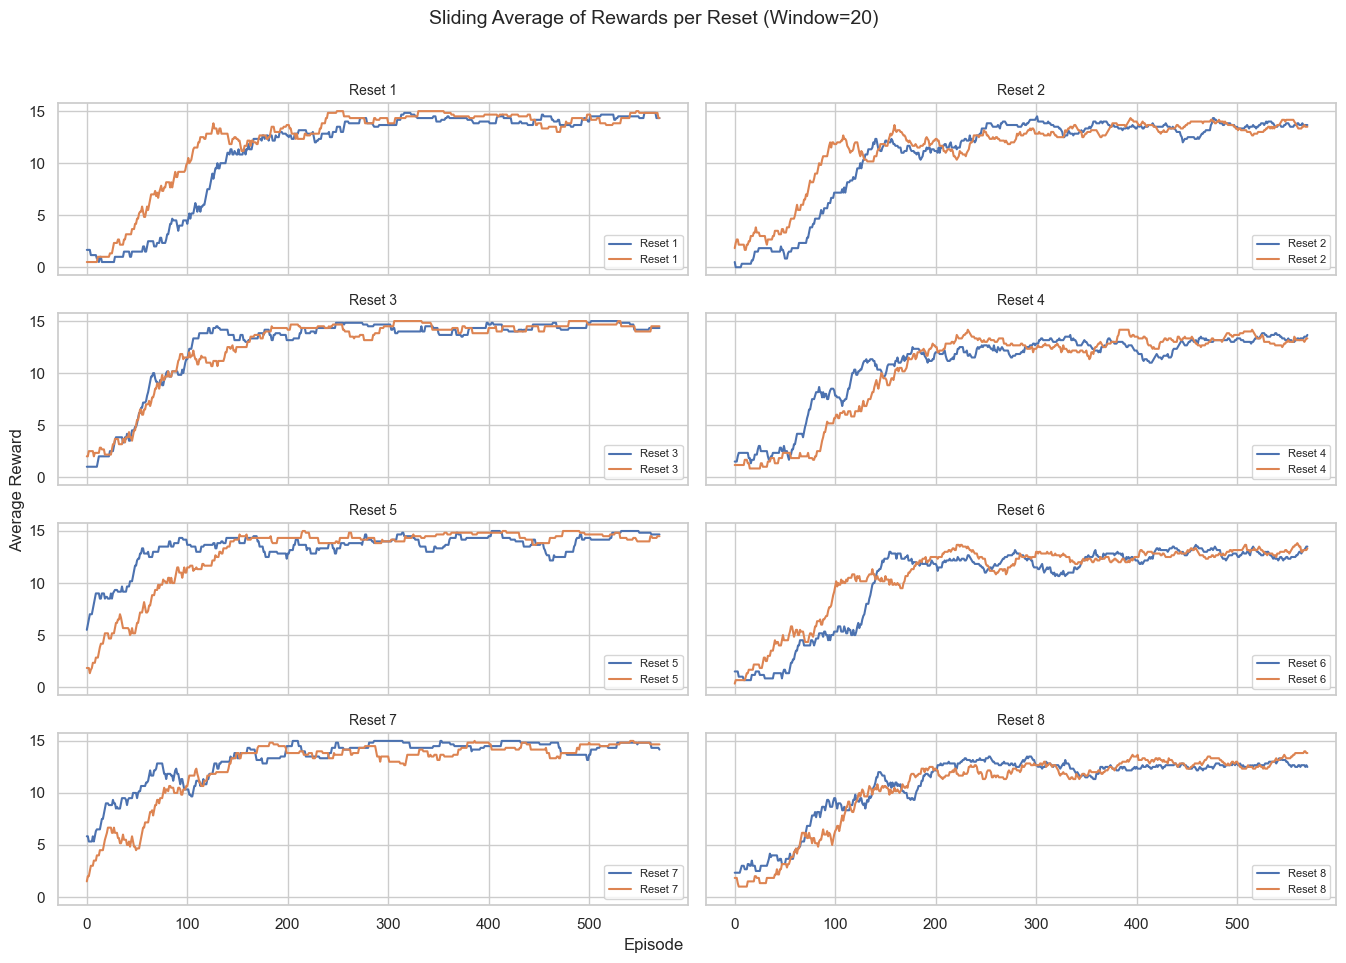

In [55]:
%pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use seaborn style
sns.set(style="whitegrid")

# Assuming total_rewards is a list of 8 lists, each with episode rewards
fig, ax = plt.subplots(4, 2, figsize=(14, 10), sharex=True, sharey=True)
ax = ax.flatten()

window = 30  # sliding average window size

for i, reward in enumerate(total_rewards):
    i = i % 8  
    reward = np.array(reward)
    # Compute sliding average
    if len(reward) >= window:
        reward_avg = np.convolve(reward, np.ones(window) / window, mode='valid')
    else:
        reward_avg = reward  # too short for convolution

    ax[i].plot(reward_avg, label=f'Reset {i+1}')
    ax[i].set_title(f'Reset {i+1}', fontsize=10)
    ax[i].legend(loc='lower right', fontsize=8)

# Common labels
fig.suptitle("Sliding Average of Rewards per Reset (Window=20)", fontsize=14)
fig.text(0.5, 0.04, 'Episode', ha='center')
fig.text(0.04, 0.5, 'Average Reward', va='center', rotation='vertical')

plt.tight_layout(rect=[0.04, 0.04, 1, 0.96])
plt.show()


In [56]:
flat_rates = total_reservoire_rates.reshape(-1, total_reservoire_rates.shape[-1])
flat_grads = total_gradients.reshape(-1, total_gradients.shape[-1])

print(flat_rates.shape)
print(flat_grads.shape)

(288000, 500)
(288000, 100)


In [57]:
np.random.seed(42)

noise_size = 0.0000005
noise = np.random.normal(0, noise_size, size=np.shape(flat_rates))
W_out = np.linalg.pinv(flat_rates + noise).dot(np.arctanh(flat_grads))

network_reservoire_gradient.Jout = W_out.T

In [60]:
from tqdm import tqdm

change_every = 600
n_resets = 16

eta = 0.008 * 0.125

dw_filt = 0
n_angle = 0

total_rewards_res = []

for n in tqdm(range(n_resets), desc='Resets', total=n_resets):
    theta0= 45/2 * n_angle
    n_angle += 1 

    env.reset(.5,.5, theta0=theta0)
    agent.weights = np.copy(agent.weights_0 * 0)

    rewards = []
    reservoire_rates = []
    gradients = []

    for episode in range(change_every):
        done = False 
        time = 0

        env.reset_inner()
        network_reservoire_gradient.reset()
        agent.update_filt = np.copy(agent.weights_0 * 0)

        reservoire_rate = []
        gradient = []
        
        while not done:
            time += 1
            if time >= TIME:
                break
            
            state = np.copy(env.agent_position)
            state_enc = encoder.encode_position(state)
            logits = agent.weights @ state_enc
            action_probs = np.exp(logits) / np.sum(np.exp(logits))
            action = np.random.choice(len(action_probs), p=action_probs)

            reward, done = env.step(action)
            weights_old = np.copy(agent.weights)
            probs = np.copy(action_probs)
            probs[action] -= 1

            r_encoded = encode(reward)

            input_modulation = .1 + gamma_grad * network_reservoire_gradient.Jin_mult * reward
            input_modulation = input_modulation.flatten()

            reservoire_input = np.concatenate((state_enc, probs, r_encoded.flatten()))
            network_reservoire_gradient.step_rate(reservoire_input, input_modulation, 0)

            dw_out = np.copy(np.reshape(network_reservoire_gradient.y,(4,spatial_res**2)))
            agent.weights += dw_out

        flat_shape = dw_out.flatten().shape
        # When the episode ends prematurely, pad the reservoire_rate and gradient lists
        if len(gradient) < TIME:
            pad_vec = np.zeros(flat_shape)
            gradient += [pad_vec] * (TIME - len(gradient))
            reservoire_rate += [np.zeros(N)] * (TIME - len(reservoire_rate))

        rewards.append(reward)  

    total_rewards_res.append(rewards)      
        
total_rewards_res = np.array(total_rewards_res)
print(total_rewards_res.shape)

Resets:   0%|          | 0/16 [00:00<?, ?it/s]c:\Users\marcu\Desktop\github repos\AML2025\FinalProject\Testing\goal_onr.py:131: RuntimeWarning: divide by zero encountered in divide
  self.H   = self.H   * np.exp(-self.dt/self.tau_m) + (1-np.exp(-self.dt/self.tau_m) ) * np.tanh( ( self.J @ self.S_hat   + self.Jin @ inp )* (inp_modulation) )
Resets: 100%|██████████| 16/16 [01:32<00:00,  5.77s/it]

(16, 600)


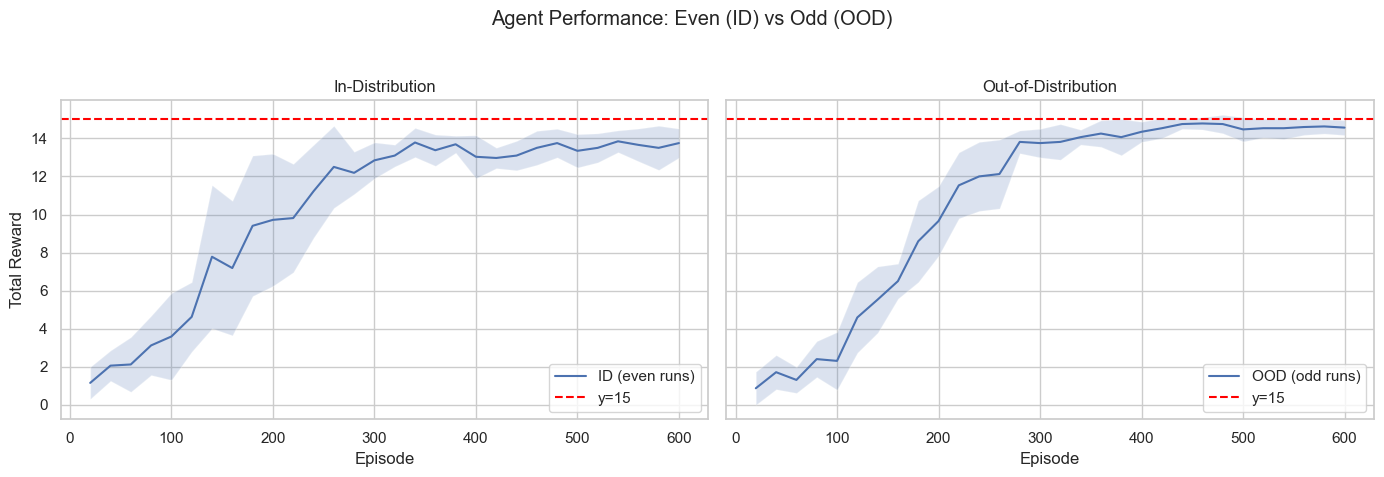

In [64]:
bin_size = 20  
hline    = 15 

indices     = np.arange(total_rewards_res.shape[0])
id_indices  = indices[indices % 2 == 0]  # 0,2,4,...
ood_indices = indices[indices % 2 == 1]  # 1,3,5,...

id_runs  = total_rewards_res[id_indices]   # shape (8, 600)
ood_runs = total_rewards_res[ood_indices]  # shape (8, 600)

def agg(r):
    # r: (runs, episodes)
    bins = r.shape[1] // bin_size
    binned = (
        r[:, : bins * bin_size]
        .reshape(r.shape[0], bins, bin_size)
        .mean(axis=2)  # (runs, bins)
    )
    return binned.mean(axis=0), binned.std(axis=0), np.arange(1, bins + 1) * bin_size

id_mean, id_std, x = agg(id_runs)
ood_mean, ood_std, _ = agg(ood_runs)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# In-Distribution (even runs)
axes[0].plot(x, id_mean, label="ID (even runs)")
axes[0].fill_between(x, id_mean - id_std, id_mean + id_std, alpha=0.2)
axes[0].axhline(hline, linestyle="--", color="red", label=f"y={hline}")
axes[0].set_title("In-Distribution")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Total Reward")
axes[0].grid(True)
axes[0].legend()

# Out-of-Distribution (odd runs)
axes[1].plot(x, ood_mean, label="OOD (odd runs)")
axes[1].fill_between(x, ood_mean - ood_std, ood_mean + ood_std, alpha=0.2)
axes[1].axhline(hline, linestyle="--", color="red", label=f"y={hline}")
axes[1].set_title("Out-of-Distribution")
axes[1].set_xlabel("Episode")
axes[1].grid(True)
axes[1].legend()

fig.suptitle("Agent Performance: Even (ID) vs Odd (OOD)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()